In [1]:
import os
import argparse
import time
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchsde

from functools import partial
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw

from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    
    
def visualize_2d(true_y=None, pred_y=None, times=None, save=None, title='', xmin=-2., xmax=2., show=False):
    fig = plt.figure(figsize=(8,4))
    ax_traj = fig.add_subplot(1, 2, 1)
    ax_phase = fig.add_subplot(1, 2, 2)
    if title is not None:
        fig.suptitle(title)
        
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(times.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], times.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
    if pred_y!=None:
        ax_traj.plot(times.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], '--', times.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(xmin, xmax)
    ax_traj.legend(['Data E(t)', 'Data I(t)', 'NDE E(t)', 'NDE I(t)'])

    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.cpu().detach().numpy()[:, 0, 0], true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
    if pred_y!=None:
        ax_phase.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(xmin, xmax)
    ax_phase.set_ylim(xmin, xmax)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    if show == True:
        plt.show()

In [2]:
from typing import Sequence
import glob
import os, sys
import conley_functions as cf

In [3]:
import itertools

#2D ex: Wilson-Cowan (stable limit cycle and unstable fixed point)
class wilsoncowan_SDE(object):
    """Stochastic harmonic oscillator
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, w: Sequence = (16., 16., -12., -4.), p: Sequence = (-1., -4.), r: Sequence = (.0), sigma: Sequence = (.0, .0)):
        super().__init__()
        self.w = w
        self.p = p
        self.r = r
        self.sigma = sigma

    def f(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        w11, w12, w21, w22 = self.w
        p1, p2 = self.p
        r = self.r

        f1 = -x1 + (1-r*x1)*torch.sigmoid(w11*x1+w21*x2 + p1)
        f2 = -x2 + (1-r*x2)*torch.sigmoid(w12*x1+w22*x2 + p2)
        return torch.cat([f1, f2], dim=1)

    def g(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        sigma1, sigma2 = self.sigma

        g1 = x1 * sigma1
        g2 = x2 * sigma2
        return torch.cat([g1, g2], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs
    
def make_grid(dim, low, high, delta):
    "makes grid in dim dimensions with evenly spaced (hyper)cubes"
    n=int((high-low)/delta)+1 #+1?

    grid = []
    for coords in itertools.product(range(n),repeat=dim):
        gc = []
        for i in coords:
            gc.append(low+i*delta)
        grid.append(gc)
    return grid

In [4]:
#2D example: WC (no stoch) 
system = "stoch_wc" 
state_size = 2
t_len = 1000
device = 'cpu'
t = torch.linspace(0., 25., t_len).to(device)
sde = wilsoncowan_SDE() #sigma = 0.
y0 = torch.tensor(make_grid(state_size, .05, 1., .5)) #grid
batch_size = y0.shape[0] #batch size = numer of point on grid
ys = torchsde.sdeint(sde, y0, t)

In [5]:
#2D example: WC (no stoch) 
t_len = 100000
t = torch.linspace(0., 25., t_len).to(device)
y0 = ys[-1, ...].clone().detach()
ys = torchsde.sdeint(sde, y0, t)

In [6]:
true_y = ys
true_y0 = y0
print(true_y.shape)

torch.Size([100000, 4, 2])


Text(0, 0.5, 'I')

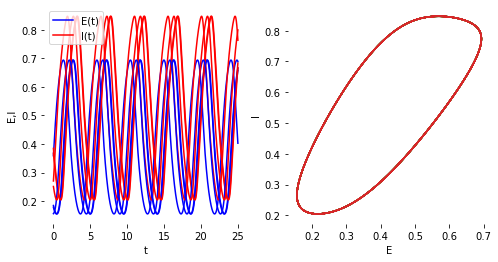

In [7]:
fig = plt.figure(figsize=(8, 4), facecolor='white')
ax_traj = fig.add_subplot(121, frameon=False)
ax_phase = fig.add_subplot(122, frameon=False)
time_shift = 0

for i in range(batch_size):
    ax_traj.plot(t.detach().numpy()[time_shift:], true_y[time_shift:,i,0].detach().numpy(), c='b')
    ax_traj.plot(t.detach().numpy()[time_shift:], true_y[time_shift:,i,1].detach().numpy(), c='r')
    ax_phase.plot(true_y[time_shift:,i,0].detach().numpy(), true_y[time_shift:,i,1].detach().numpy())
    
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('E,I')
ax_traj.legend(['E(t)', 'I(t)'])
ax_phase.set_xlabel('E')
ax_phase.set_ylabel('I')

In [8]:
#analysis
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
# sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
# sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation')
true_y[time_shift:,:,:].shape

torch.Size([100000, 4, 2])

In [418]:
#Make combinatorial dynamical system from the data
N=2
data_legth = t_len - time_shift
data_length_list = [t_len] * batch_size
hdatas = np.array(true_y[time_shift:,:,:]).reshape(-1,N) #npa[shift:,1:]
expnbin = 3
nbins = 2**expnbin
delta = 1/nbins
print(delta)
cds = cf.Combinatorial_Dynamical_System(delta)
cds.get_cubesandgraph(hdatas[:,:], nbins, data_length_list, calc_matrix=True)

0.125


In [419]:
#Get the recurrent components (Morse sets)
RCs = cds.get_recurrent_components(includeselfedges=False)
print("Number of cyclic strongly connected components: ", len(RCs))

Number of cyclic strongly connected components:  1


In [398]:
# import matplotlib.markers as markers
def plot_rcs(RCs, expnbin, save_folder=None):
    nbins = 2**expnbin
    delta = 1/nbins
    x_max = 2**expnbin
    y_max = 2**expnbin
    xs = np.arange(1, x_max+1)
    ys = np.arange(1, y_max+1)

    size = [400, 400] # in pixels
    dpi = 3.7*(2**(10-expnbin))
    figsize = [i / dpi for i in size]
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlim([0, x_max + 1])
    ax.set_ylim([0, y_max + 1]) 

    plt.xlabel("E rate", size=5)
    plt.ylabel("I rate", size=5)
    ax.set_xticks([0,2**(expnbin-1),2**expnbin])
    ax.set_yticks([0,2**(expnbin-1),2**expnbin])
    ax.set_xticklabels([0.,.5,1.], size=5)
    ax.set_yticklabels([0.,.5,1.], size=5)

    marker = markers.MarkerStyle(marker='s')
    for i in range(len(RCs)):
        for x,y in np.array(RCs[i]):
            plt.scatter([x-delta], [y-delta], color='green', marker=marker)
    if save_folder != None:
        plt.savefig(save_folder + "/wc_inv_cubical_%s.pdf"%expnbin)

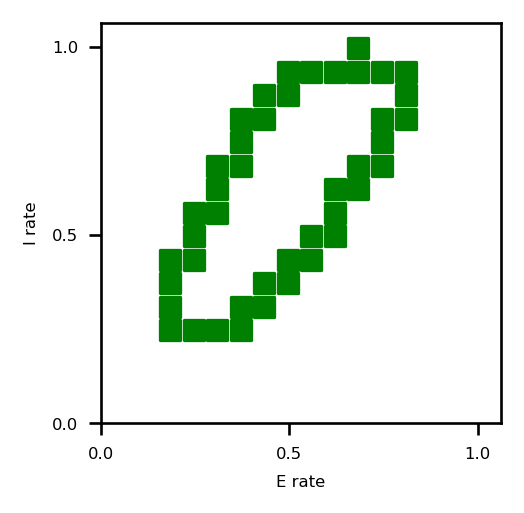

In [399]:
save_folder = "convergence"
makedirs(save_folder)

plot_rcs(RCs, expnbin, save_folder=save_folder)

In [420]:
tuplecubes = [tuple(np.array(RCs[0][i])/2**expnbin) for i in range(len(RCs[0]))]
cubes = np.array(list(tuplecubes))-delta/2.

tuplecubes = [tuple(cube) for cube in cubes]

print("Calculating Betti numbers")
bettinumbers = cf.get_bettiNumbers_of_cubicalset(tuplecubes, cds.delta)
for i, bettinumber in enumerate(bettinumbers):
    print("H_%s ="%i, bettinumber)

Calculating Betti numbers
H_0 = 1
H_1 = 3


In [304]:
# #demonstrate convergense with limit to smaller grid
N=2
hdatas = np.array(true_y[time_shift:,:,:]).reshape(-1,N)
data_length_list = [t_len] * batch_size

Nsteps = 9
expnbins = range(1,Nsteps)
homologies = np.zeros((Nsteps-1,2))
for expnbin in expnbins:
    nbins = 2**expnbin
    delta = 1/nbins
    print("Grid size: 2^" + str(-expnbin))
    
    cds = cf.Combinatorial_Dynamical_System(delta)
    cds.get_cubesandgraph(hdatas, nbins, data_length_list, calc_matrix=True)
    
    RCs = cds.get_recurrent_components(includeselfedges=False)
    print("Number of cyclic strongly connected components: ", len(RCs))
    
    tuplecubes = [tuple(np.array(RCs[0][i])/2**expnbin) for i in range(len(RCs[0]))]
    cubes = np.array(list(tuplecubes))-delta/2.

    tuplecubes = [tuple(cube) for cube in cubes]

    bettinumbers = cf.get_bettiNumbers_of_cubicalset(tuplecubes, cds.delta)
    for i, bettinumber in enumerate(bettinumbers):
        print("H_%s ="%i, bettinumber)
    homologies[expnbin-1,:] = bettinumbers
    
    

Grid size: 2^-1
Number of cyclic strongly connected components:  1
H_0 = 1
H_1 = 0
Grid size: 2^-2



KeyboardInterrupt



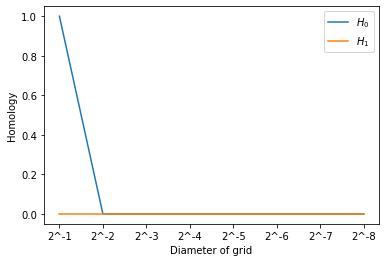

In [347]:
plt.plot(expnbins, homologies, label=['$H_0$','$H_1$'])
plt.xlabel("Diameter of grid")
plt.ylabel("Homology")
plt.legend()
plt.xticks(expnbins, ["2^-%s"%eb for eb in expnbins
                     ])
plt.savefig(save_folder + "/homology_convergence.pdf")

In [414]:
import networkx as nx
import subprocess

#psychocurves
import glob
import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation")
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\Conley")
sys.path.append("C:\\Users\\abel_\\Documents\\CHomP")
sys.path.append("/home/abel/Documents/CHomP/build/bin")
import sys
sys.path.append('../')
# C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\Conley

In [421]:
RPcubes = {}

for i in range(0,len(RCs)):#range(0,1)
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(RCs[i])
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    Nbhd = RPcubes[i][0]
    print("Finding isolated nbhd")
    S = cds.invariantPart(Nbhd)
    M = cds.cubical_wrap(S).intersection(cds.G.nodes())
#     for mstep in range(1):
#         M = cds.cubical_wrap(M).intersection(cds.G.nodes())
    
    #calculate index pair
    try:
        print("Calculating index pair")
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
    
        #write index pairs to file for Conley index calcualtion with CHomP
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)
        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        print("Calculating homology")
        proc = subprocess.Popen(['/home/abel/Documents/CHomPfull/bin/homcubes', '-i',
                                 'rc%s_P1_map.map'%(i+1), 
                                 'rc%s_P1_cubes.cub'%(i+1),
                                 'rc%s_P0_cubes.cub'%(i+1)], stdout=subprocess.PIPE)
        linenum = 0
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            print("           "+line.rstrip().decode('UTF-8'))
#             if line.rstrip().decode('UTF-8')[0] in ['H', '	', 'D', 'F'] and not line.rstrip().decode('UTF-8')[1] == 'O':
# #             if line.rstrip().decode('UTF-8')[0:2] == 'H_' or line.rstrip().decode('UTF-8')[0:2] == '  ' or line.rstrip().decode('UTF-8')[0:2] == 'Di':
                
#                 print("           "+line.rstrip().decode('UTF-8'))
#             linenum+=1
            
    except Exception as e:
        if e=='too many values to unpack (expected 4)':
            print('Failed')
        else:
            print(e)

Component 1
Finding isolated nbhd
Calculating index pair
Calculating homology
           HOMCUBES, ver. 3.07, 09/25/15. Copyright (C) 1997-2015 by Pawel Pilarczyk.
           This is free software. No warranty. Consult 'license.txt' for details.
           Note: The empty file 'rc1_P0_cubes.cub' is assumed to contain cubes.
           Reading cubes to X from 'rc1_P1_cubes.cub'... 19 cubes read.
           Reading cubes to A from 'rc1_P0_cubes.cub'... 0 cubes read.
           300 bit fields allocated (0 MB) to speed up 2-dimensional reduction.
           Reducing full-dim cubes from X... .         *         9 removed, 10 left.
           Note: The program assumes that the input map is acyclic.
           Reading the map on X from 'rc1_P1_map.map'... Done.
           Verifying if the image of X is contained in Y... Passed.
           Computing the image of the map... and of the inclusion... 19 cubes.
           Reducing full-dim cubes from Y... .         0 removed, 19 left.
           Tr

In [424]:
with open('rc%s_P1_map.map'%(i+1), 'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]

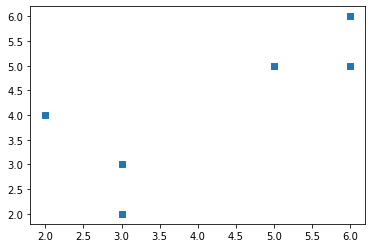

In [461]:
# import pychomp
x = lines[0].split('->')[-1][1:]

import ast

# ast.literal_eval(x)
y = x.replace("{","[").replace("}","]").replace(") ","),")
y
z = np.array(ast.literal_eval(y))
plt.scatter(z[:,0], z[:,1], marker='s', )

In [355]:
drcs = cds.convert_to_interval_representation(RCs[0])
cf.get_bettiNumbers_of_cubicalset(drcs, cds.delta)

E = cf.cubicalChainGroups(drcs, delta)
D = cf.boundaryOperatorMatrix(E, delta)

tuplecubes = [tuple(np.array(RCs[0][i])/2**expnbin) for i in range(len(RCs[0]))]
cf.get_bettiNumbers_of_cubicalset(tuplecubes, cds.delta)

E = cf.cubicalChainGroups(tuplecubes, delta)
D = cf.boundaryOperatorMatrix(E, cds.delta)

cube = tuplecubes[0]
cf.boundaryOperator(cube, delta)
relcoord = np.where( np.abs(np.mod(cube, delta)-delta/2.) < 0.00001)[0]
k = relcoord.shape[0]
np.abs(np.mod(cube, delta)-delta/2.)
cube, delta
np.mod(cube, delta)

cf.primaryFaces([0., .5], 1.)
cube = [0., .5]
np.abs(np.mod(cube, 1))-1/2.
cf.primaryFaces([0., .5], 1.)

cubes = np.array(list(tuplecubes))-delta/2.
# cube, cf.primaryFaces(cube, delta), delta, np.abs(np.mod(cube, delta))-delta/2.



tuplecubes = [tuple(cube) for cube in cubes]
# E = cf.cubicalChainGroups(tuplecubes, delta)
# D = cf.boundaryOperatorMatrix(E, cds.delta)

bettinumbers = cf.get_bettiNumbers_of_cubicalset(tuplecubes, cds.delta)
for i, bettinumber in enumerate(bettinumbers):
    print("H_%s ="%i, bettinumber)

H_0 = 1
H_1 = 1


In [356]:
# proc = subprocess.Popen(['homcubes', '-i',
#                                  'rc%s_P1_map.map'%(i+1), 
# #                                  'rc%s_P1_cubes.cub'%(i+1),
# #                                  'rc%s_P0_cubes.cub'%(i+1)
#                         ],
#                                     stdout=subprocess.PIPE, shell=True)

# linenum = 0
# while True:
#     line = proc.stdout.readline()
#     if not line:
#         break
#     print("           "+line.rstrip().decode('UTF-8'))
#     linenum+=1

In [381]:
proc = subprocess.Popen(['/home/abel/Documents/CHomPfull/bin/chkmvmap', 'rc%s_P1_map.map'%(1)],
                                    stdout=subprocess.PIPE)

linenum = 0
while True:
    line = proc.stdout.readline()
    if not line:
        break
    print("           "+line.rstrip().decode('UTF-8'))
    linenum+=1

           CHKMVMAP, ver. 0.08. Copyright (C) 1997-2016 by Pawel Pilarczyk.
           This is free software. No warranty. Consult 'license.txt' for details.
           Reading F from 'rc1_P1_map.map'... 87 images read.
           Extracting the domain of F... 87 cubes.
           Extracting the range of F... 87 cubes.
           Checking if F is defined on X\A... Passed.
           Checking if F is defined on A... Passed.
           Verifying that F(X\A) is contained in Y... Passed.
           300 bit fields allocated (0 MB) to speed up 2-dimensional reduction.
           <The following computations may take a lot of time. Press Ctrl-C to interrupt.>
           Creating a cell complex of X... 522 cells.
           Verifying that images are acyclic... :(  0 :(  0        17 1        26Failed.
           --- Error: 287 images of cells from X are not acyclic. ---
           (522 images of size 1 to 31, average 9.85441, were processed.)
           1 errors, 0 warnings.
           
        

In [358]:
# !pip install pychomp
